# Imports

In [1]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import shap

from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import preprocessing


pd.options.display.max_columns = None
pd.set_option('display.max_rows', 500)

training = True
seed=42

# Functions


In [2]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    if any(y_true == 0):
        output = mean_absolute_error(y_true, y_pred)/ y_true.mean()
    else:
        output = np.mean(np.abs((y_true - y_pred) / y_true))       
    return output*100



def cat_encoding(df, cat_vars:str, encoding:str = 'label'):
    
    if encoding == 'label':
        lb_encoder = preprocessing.LabelEncoder()
        df_out = lb_encoder.fit_transform(df[cat_vars])
    if encoding == 'one_hot':
        df_out = pd.get_dummies(df,columns = cat_vars)
        
    return df_out

# Loading Data

In [36]:
anac_df = pd.read_csv("data.csv", low_memory=False)
feriados = pd.read_csv("feriados.csv")

In [3]:
anac_df.shape

(3549883, 52)

In [4]:
anac_df.head()

,id_basica,sg_empresa_icao,nm_empresa,nm_pais,ds_tipo_empresa,ds_di,ds_grupo_di,ds_tipo_linha,ds_servico_tipo_linha,nr_etapa,nr_ano_partida_real,nm_semestre_partida_real,nm_trimestre_partida_real,hr_partida_real,dt_partida_real,nm_mes_partida_real,nr_mes_partida_real,nm_dia_semana_partida_real,nr_dia_partida_real,sg_iata_origem,nm_pais_origem,nm_regiao_origem,sg_uf_origem,nm_municipio_origem,nr_escala_destino,hr_chegada_real,dt_chegada_real,nm_mes_chegada_real,nr_mes_chegada_real,nm_dia_semana_chegada_real,nr_dia_chegada_real,sg_iata_destino,nm_pais_destino,nm_regiao_destino,sg_uf_destino,nm_municipio_destino,nr_assentos_ofertados,nr_passag_pagos,nr_passag_gratis,sg_equipamento_icao,lt_combustivel,km_distancia,nr_horas_voadas,kg_payload,kg_bagagem_livre,kg_bagagem_excesso,kg_carga_paga,kg_peso,nr_velocidade_media,nr_carga_paga_km,nr_ask,nr_rpk
0,12017235,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,REGULAR PREVISTO EM HOTRAN,REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,2,2016.0,1º SEMESTRE,1º TRIMESTRE,06:52:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,THE,BRASIL,NORDESTE,PI,TERESINA,NaN,08:23:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,REC,BRASIL,NORDESTE,PE,RECIFE,118,83,0,E195,3442,937.0,"1,52",16842,1100,6,77,7408,"616,393",72149,110566.0,77771.0
1,12017070,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,01:43:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,NaN,02:37:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,70,0,0,AT72,684,225.0,"0,9",7435,0,0,0,0,"250,491",0,15750.0,0.0
2,12017071,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,02:58:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,IOS,BRASIL,NORDESTE,BA,ILHÉUS,NaN,04:51:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,70,33,0,AT72,1392,687.0,"1,88",7390,592,0,0,3067,"365,32",0,48090.0,22671.0
3,12017072,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,FRETAMENTO,NÃO REGULAR,DOMÉSTICA MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,05:15:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCZ,BRASIL,NORDESTE,AL,RIO LARGO,NaN,06:32:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,SSA,BRASIL,NORDESTE,BA,SALVADOR,70,0,0,AT72,911,468.0,"1,28",7535,0,0,0,150,"365,496",0,32760.0,0.0
4,12017082,AZU,AZUL LINHAS AÉREAS BRASILEIRAS S.A.,BRASIL,TRANSPORTE AÉREO REGULAR,EXTRA SEM HOTRAN,NÃO REGULAR,INTERNACIONAL MISTA,PASSAGEIRO,1,2016.0,1º SEMESTRE,1º TRIMESTRE,13:25:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,VCP,BRASIL,SUDESTE,SP,CAMPINAS,NaN,22:24:00,2016-01-01,JANEIRO,1.0,SEXTA-FEIRA,1.0,MCO,ESTADOS UNIDOS DA AMÉRICA,NaN,NaN,"ORLANDO, FLORIDA",266,260,6,A332,59747,6792.0,"8,98",49489,4665,0,619,25234,"756,301",4204250,1806670.0,1765920.0


In [5]:
feriados.shape

(57, 3)

In [6]:
feriados.head()

,data,fl_feriado,desc_feriado
0,2016-01-01,1,confraternização universal (feriado nacional)
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo)
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional)


# Filter Route CGH - SDU

In [37]:
df_sp = anac_df.query("sg_iata_origem == 'CGH' & sg_iata_destino == 'SDU' & nr_passag_pagos != 0")

In [9]:
df_sp.shape

(79206, 52)

# Feature Engineering

## Holyday Variables

In [38]:
# creating variables for 1 and 2 days before a holyday

feriados['data_d1'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=1)).date()))
feriados['data_d2'] = feriados.data.apply(lambda x: str((datetime.strptime(x, '%Y-%m-%d')- timedelta(days=2)).date()))
feriados['fl_feriado_d1'] = feriados.fl_feriado
feriados['fl_feriado_d2'] = feriados.fl_feriado

In [33]:
feriados.head()

,data,fl_feriado,desc_feriado,data_d1,data_d2,fl_feriado_d1,fl_feriado_d2
0,2016-01-01,1,confraternização universal (feriado nacional),2015-12-31,2015-12-30,1,1
1,2016-02-09,1,(terça-feira ) – Carnaval (ponto facultativo),2016-02-08,2016-02-07,1,1
2,2016-02-10,1,(quarta-feira ) – Quarta-feira Cinzas (ponto...,2016-02-09,2016-02-08,1,1
3,2016-03-25,1,(sexta-feira ) – Paixão Cristo (feriado naci...,2016-03-24,2016-03-23,1,1
4,2016-04-21,1,(quinta-feira) – Tirantes (feriado nacional),2016-04-20,2016-04-19,1,1


In [39]:
# joins with df_sp
df_sp = df_sp.merge(feriados[['data','fl_feriado']], left_on='dt_partida_real', right_on='data', how = 'left')
df_sp = df_sp.merge(feriados[['data_d1','fl_feriado_d1']], left_on='dt_partida_real', right_on='data_d1', how = 'left')
df_sp = df_sp.merge(feriados[['data_d2','fl_feriado_d2']], left_on='dt_partida_real', right_on='data_d2', how = 'left')

In [40]:
# filling nulls
df_sp.fillna(0,inplace=True)

In [41]:
# droping variables

keep_list = ["dt_partida_real"
             "id_basica",
             "hr_partida_real",
             "nr_dia_partida_real",
             "nm_dia_semana_partida_real",
             "nm_mes_partida_real",
             "nr_mes_partida_real",
             "fl_feriado",
             "fl_feriado_d1",
             "fl_feriado_d2",
             "hr_chegada_real",
             "nr_dia_chegada_real",
             "nm_dia_semana_chegada_real",
             "nr_ano_partida_real",
             "nr_assentos_ofertados",
             "nr_passag_pagos"]

df_sp = df_sp[keep_list]

KeyError: "['dt_partida_realid_basica'] not in index"

In [ ]:
df_sp.set_index("id_basica",inplace = True)

In [124]:
df_sp.head()

,hr_partida_real,nr_dia_partida_real,nm_dia_semana_partida_real,nm_mes_partida_real,nr_mes_partida_real,fl_feriado,fl_feriado_d1,fl_feriado_d2,hr_chegada_real,nr_dia_chegada_real,nm_dia_semana_chegada_real,nr_ano_partida_real,nr_assentos_ofertados,nr_passag_pagos
id_basica,,,,,,,,,,,,,,
12018065,14:40:00,2.0,SÁBADO,JANEIRO,1.0,0.0,0.0,0.0,15:58:00,2.0,SÁBADO,2016.0,118,64
12021813,16:55:00,7.0,QUINTA-FEIRA,JANEIRO,1.0,0.0,0.0,0.0,17:52:00,7.0,QUINTA-FEIRA,2016.0,106,81
12023749,14:40:00,9.0,SÁBADO,JANEIRO,1.0,0.0,0.0,0.0,16:13:00,9.0,SÁBADO,2016.0,118,78
12029256,14:50:00,16.0,SÁBADO,JANEIRO,1.0,0.0,0.0,0.0,15:41:00,16.0,SÁBADO,2016.0,118,99
12034688,14:47:00,23.0,SÁBADO,JANEIRO,1.0,0.0,0.0,0.0,15:41:00,23.0,SÁBADO,2016.0,118,104


## Hours 

In [42]:
# tranforming hours variables into bins of one hour interval
df_sp['hr_partida_real'] = df_sp.hr_partida_real.apply( lambda x : int(x[:2]))
df_sp['hr_chegada_real'] = df_sp.hr_chegada_real.apply( lambda x : int(x[:2]))

## Grouping Data into hourly bins

In [43]:
df_sp_grouped = df_sp.groupby(['dt_partida_real','nr_dia_partida_real','nm_dia_semana_partida_real','nr_mes_partida_real','nr_dia_chegada_real','nm_dia_semana_chegada_real','hr_partida_real','fl_feriado','fl_feriado_d1','fl_feriado_d2']).agg(nr_passag_pagos=('nr_passag_pagos', np.sum),
nr_assentos_ofertados=('nr_assentos_ofertados', np.sum), count = ('hr_partida_real', 'count')).reset_index()

In [44]:
df_sp_grouped.shape

(23571, 13)

In [45]:
df_sp_grouped.head()

,dt_partida_real,nr_dia_partida_real,nm_dia_semana_partida_real,nr_mes_partida_real,nr_dia_chegada_real,nm_dia_semana_chegada_real,hr_partida_real,fl_feriado,fl_feriado_d1,fl_feriado_d2,nr_passag_pagos,nr_assentos_ofertados,count
0,2016-01-01,1.0,SEXTA-FEIRA,1.0,1.0,SEXTA-FEIRA,8,1.0,0.0,0.0,200,426,3
1,2016-01-01,1.0,SEXTA-FEIRA,1.0,1.0,SEXTA-FEIRA,9,1.0,0.0,0.0,111,426,3
2,2016-01-01,1.0,SEXTA-FEIRA,1.0,1.0,SEXTA-FEIRA,10,1.0,0.0,0.0,102,603,4
3,2016-01-01,1.0,SEXTA-FEIRA,1.0,1.0,SEXTA-FEIRA,11,1.0,0.0,0.0,184,453,3
4,2016-01-01,1.0,SEXTA-FEIRA,1.0,1.0,SEXTA-FEIRA,12,1.0,0.0,0.0,139,282,2


# EDA

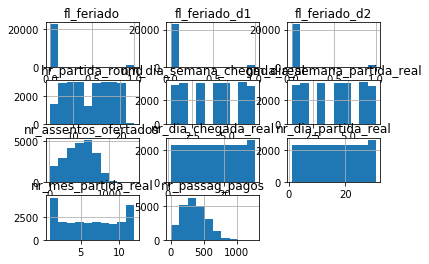

In [94]:
df_sp_grouped.hist();

In [86]:
MA_window = 10
df_sp_grouped['nr_passag_pagos'+f'_{MA_window}MA'] = df_sp_grouped.sort_values(['dt_partida_real','hr_partida_real'])['nr_passag_pagos'].rolling(window=MA_window).mean().values

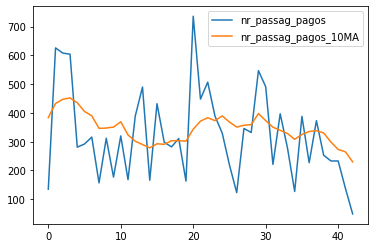

In [87]:
df_sp_grouped.query("'2019-07-06' <=dt_partida_real <= '2019-07-08' ").reset_index()[['nr_passag_pagos','nr_passag_pagos'+f'_{MA_window}MA']].plot()

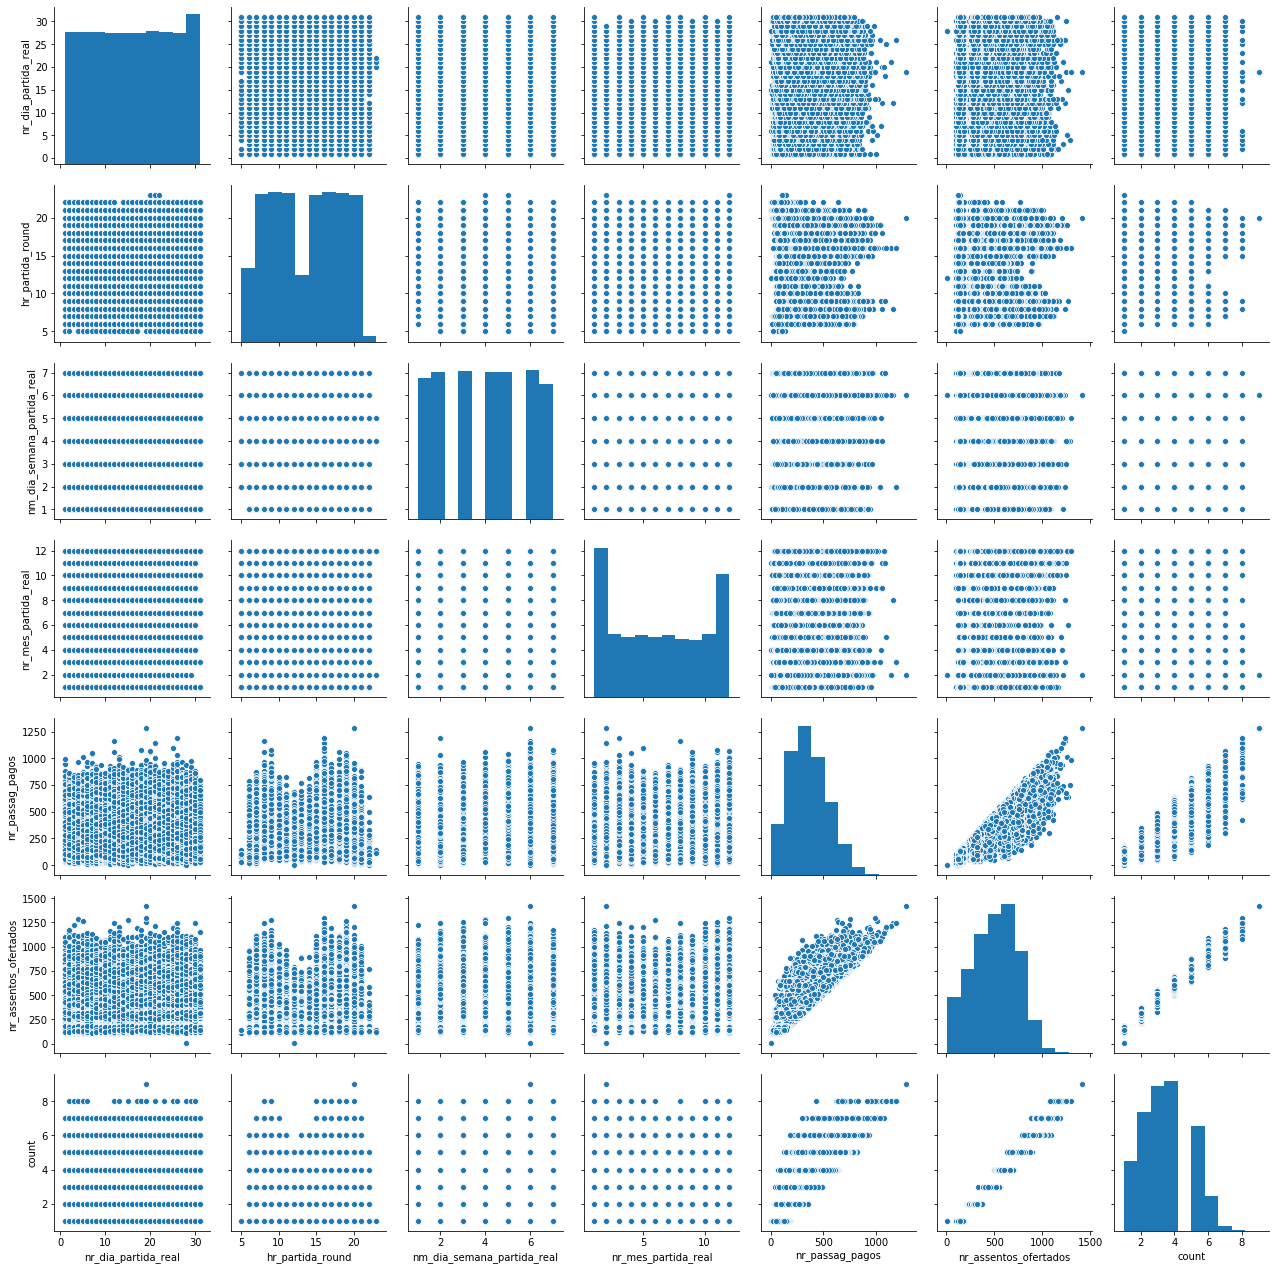

In [49]:
sns.pairplot(df_sp_grouped[['nr_dia_partida_real','hr_partida_round','nm_dia_semana_partida_real','nr_mes_partida_real','nr_passag_pagos','nr_assentos_ofertados','count']]);

# Modeling One Hot Encoding

In [12]:
# Encoding days of the week and month variables
cat_vars = df_sp_grouped.select_dtypes(include='object').columns.values.tolist()
df_sp_grouped = cat_encoding(df_sp_grouped,cat_vars, encoding = 'one_hot')

## Random Forests

In [13]:
X = df_sp_grouped.drop(['nr_passag_pagos','dt_partida_real'],axis=1)
y = df_sp_grouped.nr_passag_pagos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [152]:
X.head()

,nr_dia_partida_real,nr_mes_partida_real,nr_dia_chegada_real,hr_partida_real,fl_feriado,fl_feriado_d1,fl_feriado_d2,nr_assentos_ofertados,count,nm_dia_semana_partida_real_DOMINGO,nm_dia_semana_partida_real_QUARTA-FEIRA,nm_dia_semana_partida_real_QUINTA-FEIRA,nm_dia_semana_partida_real_SEGUNDA-FEIRA,nm_dia_semana_partida_real_SEXTA-FEIRA,nm_dia_semana_partida_real_SÁBADO,nm_dia_semana_partida_real_TERÇA-FEIRA,nm_dia_semana_chegada_real_DOMINGO,nm_dia_semana_chegada_real_QUARTA-FEIRA,nm_dia_semana_chegada_real_QUINTA-FEIRA,nm_dia_semana_chegada_real_SEGUNDA-FEIRA,nm_dia_semana_chegada_real_SEXTA-FEIRA,nm_dia_semana_chegada_real_SÁBADO,nm_dia_semana_chegada_real_TERÇA-FEIRA
0,1.0,1.0,1.0,8,1.0,0.0,0.0,177,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1.0,1.0,1.0,9,1.0,0.0,0.0,441,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1.0,1.0,1.0,10,1.0,0.0,0.0,465,3,1,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1.0,1.0,1.0,11,1.0,0.0,0.0,321,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1.0,1.0,1.0,12,1.0,0.0,0.0,276,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0


In [14]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators' : [850,900,950],
                  'max_depth' : [15,20,25]}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'max_depth': 20, 'n_estimators': 900}


In [15]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))

train MAE: 20.81
test MAE: 48.31
train MAPE: 7.43%
test MAPE: 16.75%
train RMSE: 28.11
test RMSE: 67.64


## Gradient Boosting sklearn

In [155]:
if training:
    gb = GradientBoostingRegressor(random_state=seed)
    
    param_grid = {'n_estimators': [2300,2500,2800], 
                     'max_depth': [7,8]}
    
    grid = GridSearchCV(gb, param_grid=param_grid, cv=5,return_train_score = True).fit(X_train, y_train)

    reg_gb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'max_depth': 7, 'n_estimators': 2300}


In [158]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_gb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_gb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_gb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_gb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_gb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_gb.predict(X_test))**0.5))

train MAE: 5.29
test MAE: 42.40
train MAPE: 2.00%
test MAPE: 14.80%
train RMSE: 7.86
test RMSE: 59.39


## XGBoosting

In [74]:
if training:

    reg_xgb = xgb.XGBRegressor()

    param_grid = { 'learning_rate': [0.01, 0.05], #so called `eta` value
                         'max_depth': [6, 7, 8],
                      'n_estimators': [2300,2500,2800]}

    grid = GridSearchCV(reg_xgb, param_grid=param_grid, cv=5,return_train_score = True).fit(X_train, y_train)

    reg_xgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

[20:02:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:03:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:04:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[20:36:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:36:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:38:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:39:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:40:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [75]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_xgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_xgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_train, reg_xgb.predict(X_train))))
print("train MAPE: {:.2f}%".format(100*MAPE(y_test, reg_xgb.predict(X_test))))

train MAE: 21.07
test MAE: 41.30
train MAPE: 14.59%
train MAPE: 28.56%


# With One Hot Encoding

In [35]:
X = pd.get_dummies(df_sp_grouped, columns=["nm_dia_semana_partida_real",
                                            "nr_mes_partida_real",
                                            "nm_dia_semana_chegada_real"], prefix=["dia_semana_partida_","mes_partida_","dia_semana_chegada_"])
X.drop(['nr_passag_pagos','dt_partida_real','excess_offer'],axis=1,inplace = True)

y = df_sp_grouped.nr_passag_pagos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

In [24]:
X.shape

(23571, 23)

In [39]:
if training:

    rf = RandomForestRegressor(random_state=seed, n_jobs=-1)

    param_grid = {'n_estimators' : [650,700,750],
                  'max_depth' : [3,6,15],
                  'max_features':['auto']}

    grid = GridSearchCV(rf, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_rf = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 700}


In [40]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_rf.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_rf.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_rf.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_rf.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_rf.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_rf.predict(X_test))**0.5))

train MAE: 31.45
test MAE: 48.13
train MAPE: 10.61%
test MAPE: 18.48%
train RMSE: 42.44
test RMSE: 66.11


# lightGBM

In [57]:
if training:

    lg = lgb.LGBMRegressor(random_state=seed,n_jobs=-1)

    param_grid = {'n_estimators' : [900,1000,1100],
                  'num_leaves' : [25,30,3]}

    grid = GridSearchCV(lg, param_grid=param_grid, cv=5,return_train_score = True,scoring = 'neg_mean_absolute_error').fit(X_train, y_train)
    
    #neg_root_mean_squared_error
    reg_lgb = grid.best_estimator_.fit(X_train,y_train)

    print(grid.best_params_)
   # print(grid.cv_results_)


{'n_estimators': 1100, 'num_leaves': 30}


In [51]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))

train MAE: 25.42
test MAE: 41.34
train MAPE: 9.45%
test MAPE: 15.50%
train RMSE: 33.80
test RMSE: 57.02


In [58]:
print("train MAE: {:.2f}".format(mean_absolute_error(y_train,reg_lgb.predict(X_train))))
print("test MAE: {:.2f}".format(mean_absolute_error(y_test,reg_lgb.predict(X_test))))
print("train MAPE: {:.2f}%".format(MAPE(y_train, reg_lgb.predict(X_train))))
print("test MAPE: {:.2f}%".format(MAPE(y_test, reg_lgb.predict(X_test))))
print("train RMSE: {:.2f}".format(mean_squared_error(y_train, reg_lgb.predict(X_train))**0.5))
print("test RMSE: {:.2f}".format(mean_squared_error(y_test, reg_lgb.predict(X_test))**0.5))

train MAE: 26.42
test MAE: 41.40
train MAPE: 18.30%
test MAPE: 28.63%
train RMSE: 35.18
test RMSE: 57.11


# Importance of Variables

In [28]:
explainer = shap.TreeExplainer(reg_rf , approximate = True)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [31]:

rf_shap_values = explainer.shap_values(X_test.iloc[0:200,:])


#import matplotlib.pyplot as plt
#f = plt.figure()
#shap.summary_plot(rf_shap_values, X_test)

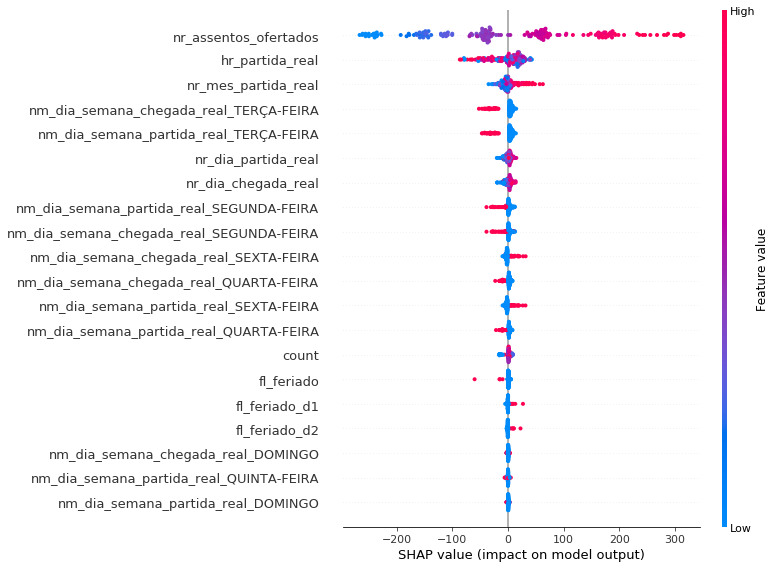

In [34]:
shap.summary_plot(rf_shap_values, X_test.iloc[0:200,:])

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value, rf_shap_values[10,:], X_test.iloc[10,:])